# Allocation Experiment

The goal here is to answer the question

- How does our model select products given a limited budget and capacity?
- How does this relate to how customers choose our products?
    - Is there another way to model the expected amount of products sold?

First we read in our data and choose some product categories.

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy as sp
import matplotlib.pyplot as plt
import time

np.random.seed(1234)
# read data
df = pd.read_csv('retail_price.csv')
index = ['product_category_name', 'product_id']
column_min = ['unit_price', 'product_score', 'freight_price', 'product_weight_g', 'comp_1', 'ps1', 
              'comp_2', 'ps2', 'comp_3', 'ps3']
# column_max = []
column_sum = ['customers']

table_min = pd.pivot_table(df, values=column_min, index=index,  aggfunc=np.min)
# table_min = pivot_table(df, values='D', index=index,  aggfunc=np.max)
table_sum = pd.pivot_table(df, values=column_sum, index=index, aggfunc=np.sum)
table = table_min.merge(table_sum, on=index,how='left')
table

comp_1      comp_2      comp_3  \
product_category_name product_id                                       
bed_bath_table        bed1         74.000000   39.240000   39.240000   
                      bed2         74.000000   74.000000   39.240000   
                      bed3         74.000000   84.900000   39.240000   
                      bed4         77.933333   44.154444   39.990000   
                      bed5         89.900000  163.398710   45.950000   
computers_accessories computers1   94.900000   94.900000   77.900000   
                      computers2  114.491154  109.900000   77.900000   
                      computers3  139.990000  134.900000   78.712281   
                      computers4  114.491154  139.990000   77.900000   
                      computers5  114.491154  119.900000   77.900000   
                      computers6  114.491154  149.900000   77.900000   
consoles_games        consoles1    19.900000   19.900000   19.900000   
                      consoles2    19.900000   19.900000   19.900000   
cool_stuff            cool1        85.704286   85.704286   29.500000   
                      cool2        89.863333  116.927500   29.500000   
                      cool3        35.000000   29.500000   29.500000   
                      cool4        89.863333  116.927500   29.500000   
                      cool5        89.863333   99.990000   29.500000   
furniture_decor       furniture1   38.400000   35.000000   38.400000   
                      furniture2   69.900000   35.000000   75.000000   
                      furniture3   38.400000   35.000000   38.400000   
                      furniture4   69.900000   35.000000   78.535714   
garden_tools          garden1      49.900000   49.900000   49.900000   
                      garden10     49.900000   49.900000   49.900000   
                      garden2      49.900000   49.900000   49.900000   
                      garden3      49.900000   49.900000   49.900000   
                      garden4      49.900000   49.900000   49.900000   
                      garden5      49.900000   49.900000   49.900000   
                      garden6      49.900000   49.900000   49.900000   
                      garden7      49.900000   49.900000   49.900000   
                      garden8      49.900000   49.900000   49.900000   
                      garden9      49.900000   49.900000   49.900000   
health_beauty         health1      23.397407   79.990000   58.990000   
                      health10     23.990000   79.990000   58.990000   
                      health2      23.397407   79.990000   58.990000   
                      health3      23.990000   79.990000   58.990000   
                      health4      23.990000   79.990000   58.990000   
                      health5      19.990000   79.990000   58.799524   
                      health6      23.990000   79.990000   58.990000   
                      health7      19.990000   64.990000   58.799524   
                      health8      19.990000   79.990000   58.799524   
                      health9      19.990000   19.990000   58.799524   
perfumery             perfumery1   49.990000   56.990000   49.990000   
                      perfumery2   49.990000  116.906667  116.906667   
watches_gifts         watches1    103.792523  105.000000  132.531250   
                      watches2    103.792523  105.000000  132.531250   
                      watches3     78.000000   78.000000  132.531250   
                      watches4    103.792523  105.000000  132.531250   
                      watches5    103.792523  105.000000  132.531250   
                      watches6    103.792523  105.000000  132.531250   
                      watches7    103.792523  105.000000  132.531250   
                      watches8    103.792523  105.000000  132.531250   

                                  freight_price  product_score  \
product_category_name product_id                                 
bed_bath_table   

To make it simpler we will first just consider one product category.

In [2]:
# Selling & Buying & Rating & Probability of buying
product_category = ['computers_accessories']

selling = {}
for category in product_category:
    selling[category] = (table.loc[category]['unit_price'].values)

# we set a margin for each product that depends on their price
PROFIT_MARGIN_FACTOR = 0.3
buying = {}
for category in product_category:
#     buying[category] = selling[category] * np.random.uniform(0.6,0.7, size=np.shape(selling[category]))
    buying[category] = selling[category] * (1 - (np.exp((selling[category]**PROFIT_MARGIN_FACTOR)) 
                                                 / np.sum(np.exp((selling[category]**PROFIT_MARGIN_FACTOR)))))

rating = {}
for category in product_category:
    rating[category] = (table.loc[category]['product_score'].values)
MAX_RATING = 5.

# Customers
n_customers = {}
for category in product_category:
    n_customers[category] = (table.loc[category]['customers'].sum()) 

    
# Weight
weight = {}
for category in product_category:
    weight[category] = (table.loc[category]['product_weight_g'].values) 

print("Buying prices ", buying)
print("RRP ", selling)
print("Product ratings ", rating)
print("Weight ", weight)

Buying prices  {'computers_accessories': array([ 59.80669524,  68.76982064, 103.33506584,  93.39729425,
        68.20778189, 110.74442707])}
RRP  {'computers_accessories': array([ 66.34214286,  77.9       , 132.97      , 114.4911538 ,
        77.155     , 149.9       ])}
Product ratings  {'computers_accessories': array([4. , 3.5, 4.2, 4.2, 3.5, 4.3])}
Weight  {'computers_accessories': array([ 173,  180,  922, 6550,  207,  533], dtype=int64)}


Let's plot the buying and selling prices.

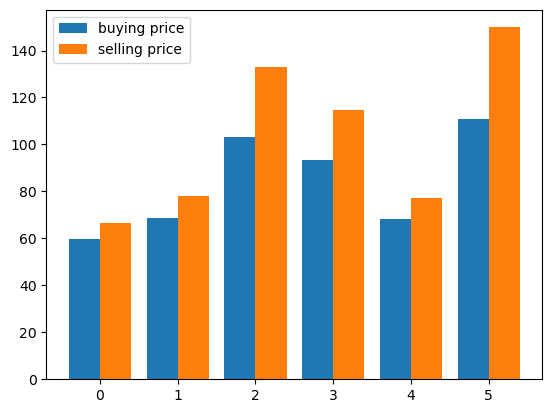

In [3]:
plt.bar(x = np.arange(6) - 0.2, height =  buying['computers_accessories'], label = 'buying price', width = 0.4)
plt.bar(x = np.arange(6) + 0.2, height = selling['computers_accessories'], label = 'selling price', width = 0.4)
plt.legend()

and the margin of each product,

Text(0, 0.5, 'Margin ($)')

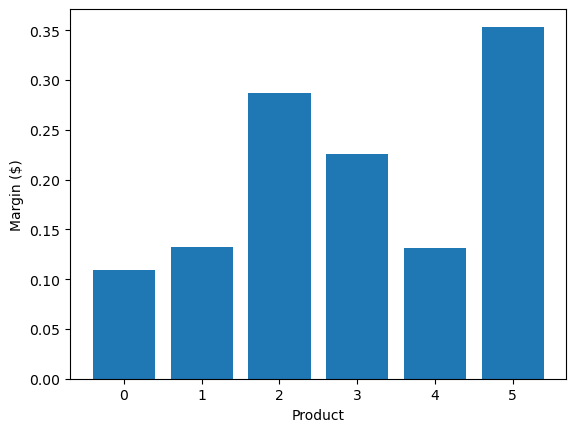

In [4]:
margin = (selling['computers_accessories'] - buying['computers_accessories']) / buying['computers_accessories']
plt.bar(x = np.arange(6),height = margin)
plt.xlabel("Product")
plt.ylabel("Margin ($)")

## Customer Allocation

As stated in our model specification we take the softmax of selling price / rating as our probability.

In [5]:
PRICE_SENSITIVITY = 1.2
softmax={}
for category in product_category:
    softmax[category] = (np.exp(-(selling[category]**PRICE_SENSITIVITY)*(MAX_RATING - rating[category]) / 100) 
              / np.sum(np.exp(-(selling[category]**PRICE_SENSITIVITY)*(MAX_RATING - rating[category])/100)))

Text(0, 0.5, 'Max Number of Customers to Buy')

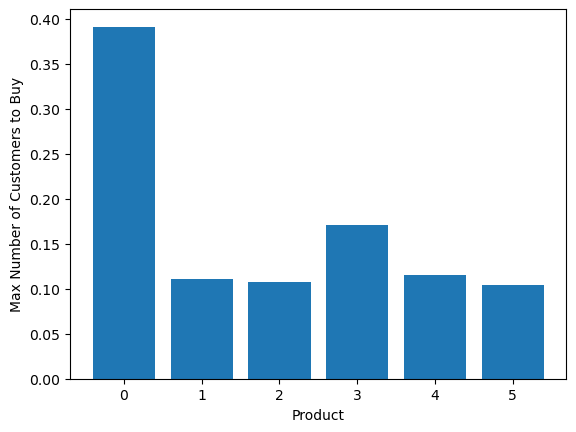

In [6]:
prop_customers = softmax['computers_accessories']
max_customers = n_customers['computers_accessories'] *prop_customers
plt.bar(np.arange(6), prop_customers)
plt.xlabel("Product")
plt.ylabel("Max Number of Customers to Buy")

Text(0, 0.5, 'Product Rating')

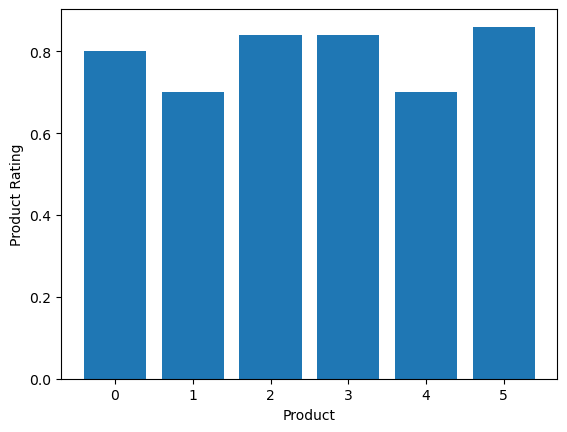

In [7]:
plt.bar(np.arange(6), rating['computers_accessories'] / 5)
plt.xlabel("Product")
plt.ylabel("Product Rating")

Immediately we can see that product $0$ has a relatively high rating and low price, so it gets assigned the high proportion of customers to buy. On the other hand, although product $5$ has the highest product rating, it has a relatively high price to the customers and so it does not get assigned as high a demand. Nevertheless we will see how our model deals with this scenario.

# Implementation in Gurobi

In [8]:
# fixed freight cost, can change if needed
SHIPPING_COST = 0.01

# how many customers we have that won't buy unless extra conditions are fufilled
MARKET_CUSTOMERS = {category: 10000 for category in product_category}

# what % of 'market' customers do we get for each % of discount?
DISCOUNT_FACTOR = 0.05

# what % of 'market' customers do we get if we have free shipping
FREE_SHIPPING_FACTOR = 0.4

# the budget
BUDGET = 1e7

# inventory for each category, we will set this to be a proportion of the number of customers
# INVENTORY_SPACE = n_customers['computers_accessories'] * 1
INVENTORY_SPACE = 1e5

In [9]:
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 20s
    if time.time() - model._time > 20:
        model.terminate()

In [10]:
def run_model():
    m = gp.Model()

    BIGNUM = 1e6 # sum(n_customers.values())

    # decision variables
    stock = {}
    is_chosen = {}
    sold = {}
    discount = {}
    free_shipping = {}
    vars = {
        'stock':stock, 'is_chosen':is_chosen, 'sold':sold, 'discount':discount, 'free_shipping':free_shipping,
    }

    # initialising decision variables
    for category in product_category:
        I = range(len(selling[category]))
        stock[category] = m.addVars(I,vtype = GRB.INTEGER)
        is_chosen[category] = m.addVars(I, vtype = GRB.BINARY)
        sold[category] = m.addVars(I,vtype = GRB.INTEGER)
        discount[category] = m.addVars(I,vtype=GRB.CONTINUOUS, lb=0, ub=1)
        free_shipping[category] = m.addVars(I,  vtype = GRB.BINARY)


    # amount sold and extra customers (100 is to rescale discount)
    captured_customers = lambda category,i: (
        MARKET_CUSTOMERS[category] * (FREE_SHIPPING_FACTOR * free_shipping[category][i]
                                    + DISCOUNT_FACTOR * discount[category][i] * 100)
    )
    amount_sold  = lambda category,i: softmax[category][i]* (n_customers[category] + captured_customers(category,i))
     
    # objective function
    m.setObjective(
        gp.quicksum(gp.quicksum(sold[category][i] * selling[category][i] * (1 - discount[category][i]) 
                                - stock[category][i] * buying[category][i]
                                - sold[category][i] * SHIPPING_COST * free_shipping[category][i] * weight[category][i]
                    for i in range(len(selling[category]))) for category in product_category),
        GRB.MAXIMIZE
    )

    # Can't store past inventory space
    m.addConstr( gp.quicksum(gp.quicksum(stock[category][i] * weight[category][i] 
                              for i in range(len(selling[category]))) for category in product_category) 
                 <= INVENTORY_SPACE)

    # Can't buy more than the budget
    m.addConstr(gp.quicksum( gp.quicksum(stock[category][i] * buying[category][i] for i in range(len(selling[category]))) 
                            for category in product_category) <= BUDGET)

    for category in product_category:
        # If a product is stocked, is_chosen is set to be 1 [Change to BIGNUM to remove dependencies on n_customers]
        m.addConstrs(stock[category][i] <= is_chosen[category][i] * BIGNUM
                    for i in range(len(selling[category])))
        # Can't sell more than you have stocked
        m.addConstrs(sold[category][i] <= stock[category][i] for i in range(len(selling[category])))
        # How much we can sell depends on number of customers [Removed is_chosen]
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        m.addConstrs(sold[category][i] <= amount_sold(category, i)
                    for i in range(len(selling[category])))
        # Can't sell more than the total number of customers
        m.addConstr(gp.quicksum(sold[category][i] for i in range(len(selling[category]))) 
                     <= n_customers[category] + MARKET_CUSTOMERS[category])
#         m.addConstrs((FREE_SHIPPING_FACTOR * free_shipping[category][i]
#                                     + DISCOUNT_FACTOR * discount[category][i]) <= 1 for i in range(len(selling[category])))

    m.params.NonConvex = 2
    
    m._cur_obj = float('inf')
    m._time = time.time()

    
    m.optimize(callback=cb)
    data = {}
    for category in product_category:
        data[category] = {}
        for v in vars:
            data[category][v] = [a.X for a in vars[v][category].values()]
    return m,data


In [11]:
m,data = run_model()
data

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-19
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0xb9cb3be6
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+07]
Found heuristic solution: objective -0.0000000
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 17 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 6 integer (1 binary)
Found heuristic solut

{'computers_accessories': {'stock': [-0.0, 1.0, -0.0, -0.0, -0.0, 187.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [0.0, 1.0, 0.0, 0.0, 0.0, 187.0],
  'discount': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'free_shipping': [0.0, -0.0, 0.0, 0.0, 0.0, 0.0]}}

-------------

# Low Budget , Low Inventory

In [12]:
BUDGET = 1e5
INVENTORY_SPACE = 1e5
m,data = run_model()
data

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0x2e98c7c4
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+05]
Found heuristic solution: objective -0.0000000
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 17 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 6 integer (1 binary)
Found heuristic solution: objective 3793.0972398

Root relaxation: objective 7.338780e+03, 1 iterations, 0.00 se

{'computers_accessories': {'stock': [-0.0, 1.0, -0.0, -0.0, -0.0, 187.0],
  'is_chosen': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  'sold': [0.0, 1.0, 0.0, 0.0, 0.0, 187.0],
  'discount': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'free_shipping': [0.0, -0.0, 0.0, 0.0, 0.0, 0.0]}}

Total amount sold:  188.0


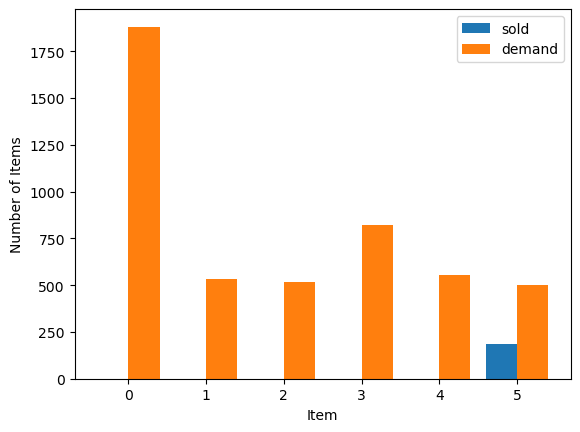

In [13]:
sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')

plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

Text(0, 0.5, 'Proportion of Total Products/Demand')

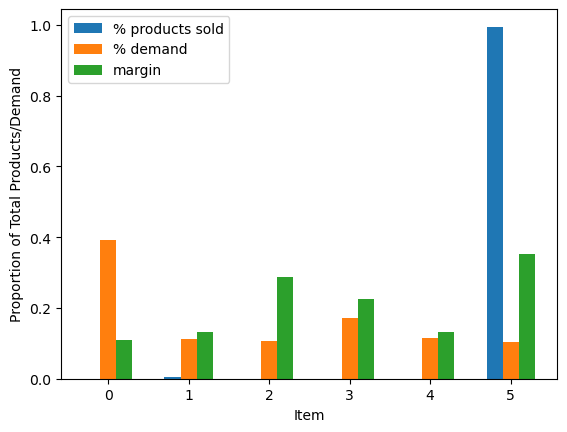

In [14]:
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

_________________

# High Budget , Low Inventory

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0xb9cb3be6
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+07]
Found heuristic solution: objective -0.0000000
Presolve removed 25 rows and 24 columns
Presolve time: 0.01s
Presolved: 6 rows, 9 columns, 17 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 6 integer (1 binary)
Found heuristic solution: objective 3793.0972398

Root relaxation: objective 7.338780e+03, 1 iterations, 0.00 se

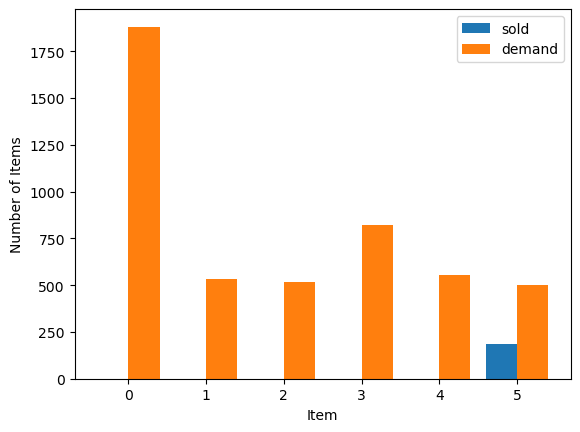

In [15]:
BUDGET = 1e7
INVENTORY_SPACE = 1e5
m,data = run_model()
print(data)

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')

plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))


Text(0, 0.5, 'Proportion of Total Products/Demand')

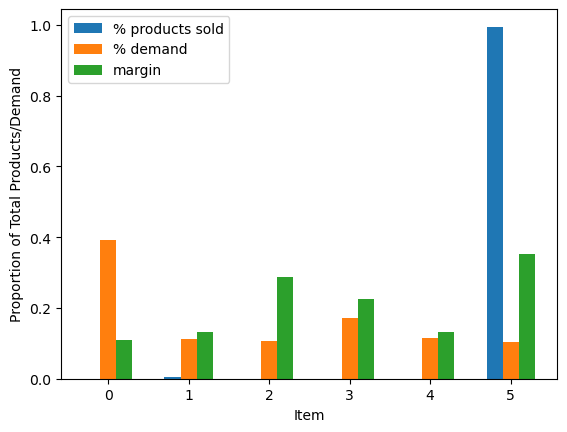

In [16]:
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

# Low Budget , High Inventory

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0x12646cd8
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 21 rows and 14 columns
Presolve time: 0.00s
Presolved: 22 rows, 27 columns, 67 nonzeros
Presolved model has 5 bilinear constraint(s)
Variable types: 11 continuous, 16 integer (5 binary)
Found heuristic solution: objective 10980.351876

Root relaxation: objective 3.493889e+04, 5 iterations, 0.0

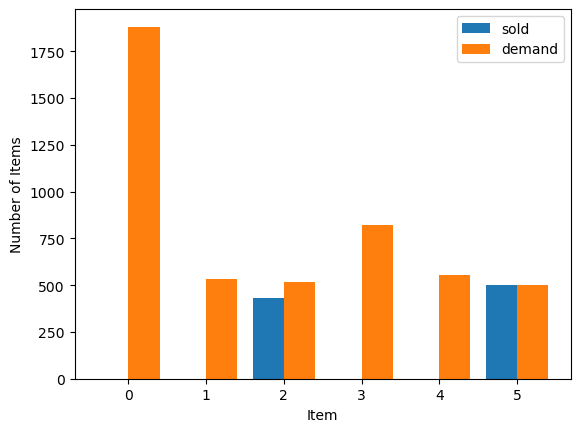

In [17]:
BUDGET = 1e5
INVENTORY_SPACE = 1e8
m,data = run_model()
print(data)

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')

plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))


# High Budget , High Inventory

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0x659b0435
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolved: 26 rows, 31 columns, 79 nonzeros
Presolved model has 6 bilinear constraint(s)
Variable types: 13 continuous, 18 integer (6 binary)
Found heuristic solution: objective 74313.679151

Root relaxation: objective 1.635683e+05, 8 iterations, 0.0

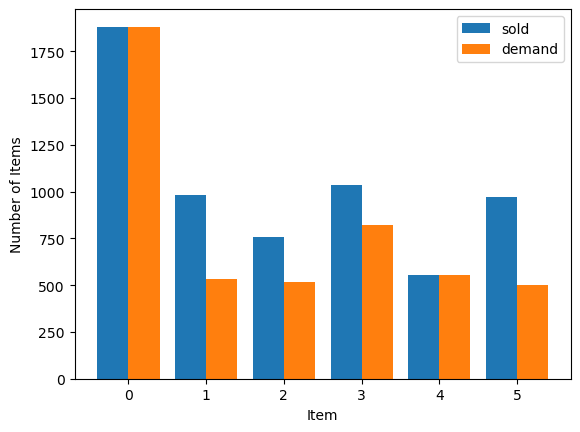

In [18]:
BUDGET = 5e5
INVENTORY_SPACE = 1e8
m,data = run_model()
print(data)

sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')

plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))


Text(0, 0.5, 'Proportion of Total Products/Demand')

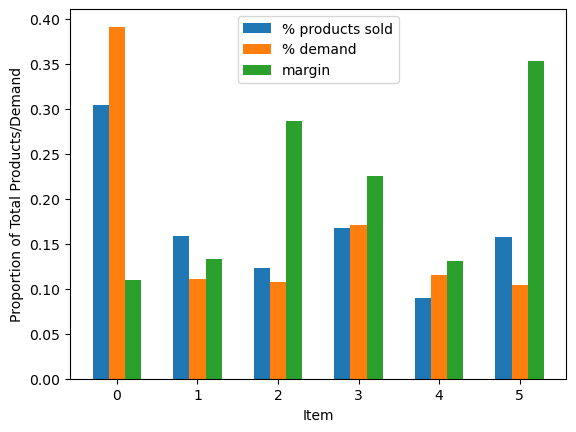

In [19]:
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

-----------------------------------

Here we have assumed 0 discount and shipping parameters and so the only question is how much of each product to choose. Let's plot the amount bought and sold.

Text(0, 0.5, 'Proportion of Total Products/Demand')

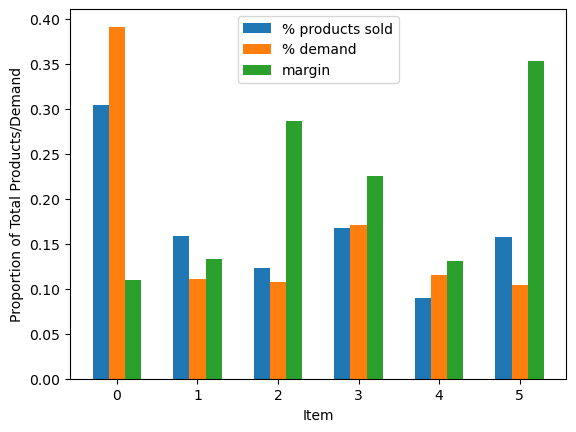

In [20]:
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

In [21]:
max_customers

array([1881.00835254,  535.16091913,  515.92031591,  821.2855162 ,
        552.56992729,  501.05496893])

In [22]:
n_customers['computers_accessories']

4807

We can see that none of the products have their total demand met; this is likely because we have limited inventory and budget. However it may be worth actually checking what affects the quantity stored for each item. Clearly demand is not the only factor since item 0, 1 and 4 have demand higher than item 5, but they were not stocked.

Text(0, 0.5, 'Proportion of Total Products/Demand')

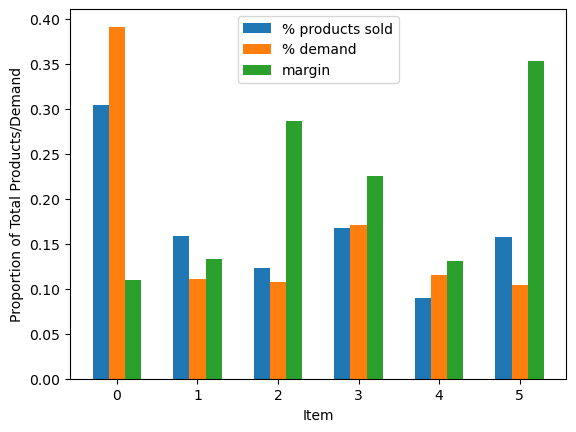

In [23]:
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

Combining our knowledge of the profit margin and the stock, when we have a low budget, we limit the type of items we stock due to limited funds, thus the obvious choice would be to stock the high profit margin items, giving better return of investment(ROI).

However, with a bigger budget:

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0xd0d1fcc4
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolved: 26 rows, 31 columns, 79 nonzeros
Presolved model has 6 bilinear constraint(s)
Variable types: 13 continuous, 18 integer (6 binary)
Found heuristic solution: objective 74313.679151

Root relaxation: objective 3.612547e+05, 16 iterations, 0.

Text(0, 0.5, 'Proportion of Total Products/Demand')

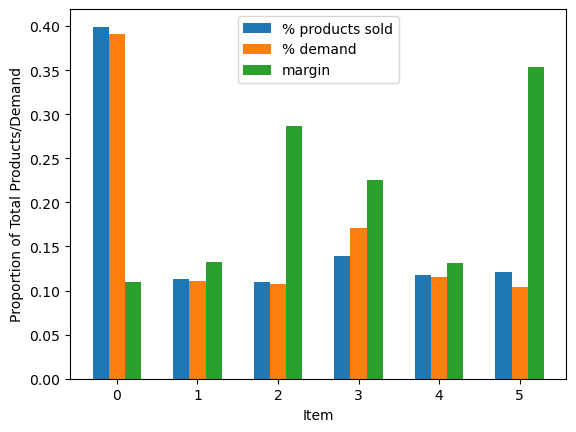

In [24]:
BUDGET = 1e7

m,data = run_model()
sold_items = data['computers_accessories']['sold']
prop_products_sold = sold_items / np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.2, label = '% products sold')
plt.bar(np.arange(6) , prop_customers, 0.2, label = '% demand')
plt.bar(np.arange(6) + 0.2, margin, 0.2, label = 'margin')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

Total amount sold:  8630.0


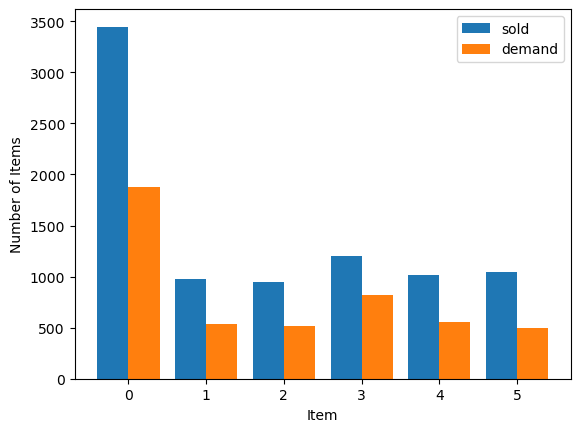

In [25]:
sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')

plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

We switch to stocking up item 

Text(0, 0.5, '% Margin')

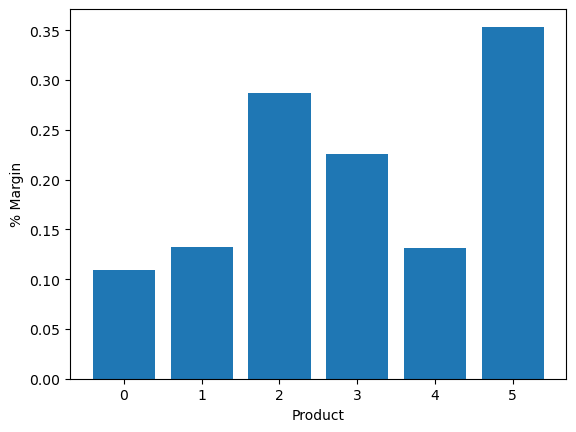

In [26]:
# buying = {}
# for category in product_category:
#     buying[category] = selling[category] * np.random.uniform(0.6,0.8,size = len(selling[category]))
    
margin = (selling['computers_accessories'] - buying['computers_accessories']) / buying['computers_accessories']
plt.bar(x = np.arange(6),height = margin)
plt.xlabel("Product")
plt.ylabel("% Margin")

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0xd0d1fcc4
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+08]
Found heuristic solution: objective -0.0000000
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolved: 26 rows, 31 columns, 79 nonzeros
Presolved model has 6 bilinear constraint(s)
Variable types: 13 continuous, 18 integer (6 binary)
Found heuristic solution: objective 74313.679151

Root relaxation: objective 3.612547e+05, 16 iterations, 0.

Text(0, 0.5, 'Proportion of Total Products/Demand')

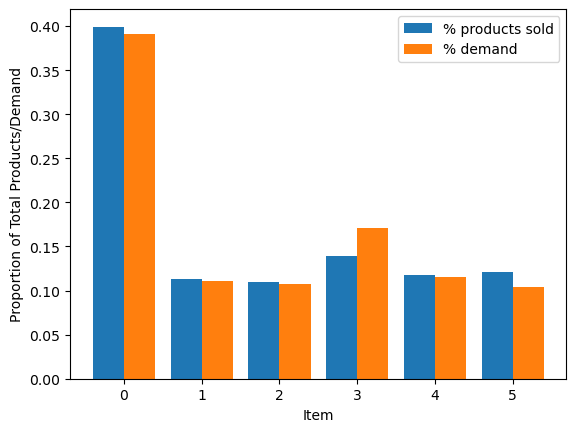

In [27]:
m,data = run_model()
sold_items = data['computers_accessories']['sold']
prop_products_sold = sold_items/ np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.4, label = '% products sold')
plt.bar(np.arange(6) + 0.2, prop_customers, 0.4, label = '% demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")

Total amount sold:  8630.0


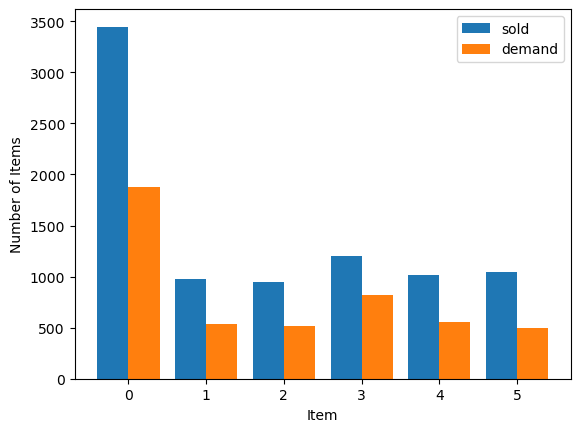

In [28]:
sold_items = data['computers_accessories']['sold']
plt.bar(np.arange(6) - 0.2, sold_items, 0.4, label = 'sold')
plt.bar(np.arange(6) + 0.2, max_customers, 0.4, label = 'demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Number of Items")
print("Total amount sold: ", np.sum(sold_items))

Still it seems that we are buying according to the demand of customers, despite the different margins. We can check with a more extreme case.

Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 27 rows, 30 columns and 78 nonzeros
Model fingerprint: 0xb9cb3be6
Model has 12 quadratic objective terms
Variable types: 6 continuous, 24 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [6e+01, 1e+02]
  QObjective range [3e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 1e+07]
Found heuristic solution: objective -0.0000000
Presolve removed 25 rows and 24 columns
Presolve time: 0.00s
Presolved: 6 rows, 9 columns, 17 nonzeros
Presolved model has 1 bilinear constraint(s)
Variable types: 3 continuous, 6 integer (1 binary)
Found heuristic solution: objective 3793.0972398

Root relaxation: objective 7.338780e+03, 1 iterations, 0.00 se

Text(0, 0.5, 'Proportion of Total Products/Demand')

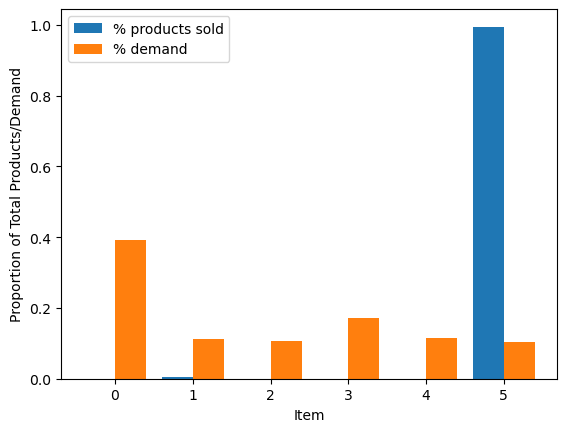

In [29]:
#buying['computers_accessories'][5] = 0.
INVENTORY_SPACE = 100000
m,data = run_model()
sold_items = data['computers_accessories']['sold']
prop_products_sold = sold_items/ np.sum(sold_items)
plt.bar(np.arange(6) - 0.2, prop_products_sold, 0.4, label = '% products sold')
plt.bar(np.arange(6) + 0.2, prop_customers, 0.4, label = '% demand')
plt.legend()
plt.xlabel("Item")
plt.ylabel("Proportion of Total Products/Demand")